## Importing Relevant Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Reading Dataset

In [8]:
df=pd.read_csv('/content/train.csv',encoding='utf8',nrows=100000)

In [9]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [10]:
df.shape

(100000, 6)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            100000 non-null  int64 
 1   qid1          100000 non-null  int64 
 2   qid2          100000 non-null  int64 
 3   question1     100000 non-null  object
 4   question2     100000 non-null  object
 5   is_duplicate  100000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


### Intial EDA

In [12]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [13]:
df.duplicated().sum()

0

Percentage Of is_duplicate Distribution:
is_duplicate
0    62.746
1    37.254
Name: count, dtype: float64


<Axes: xlabel='is_duplicate'>

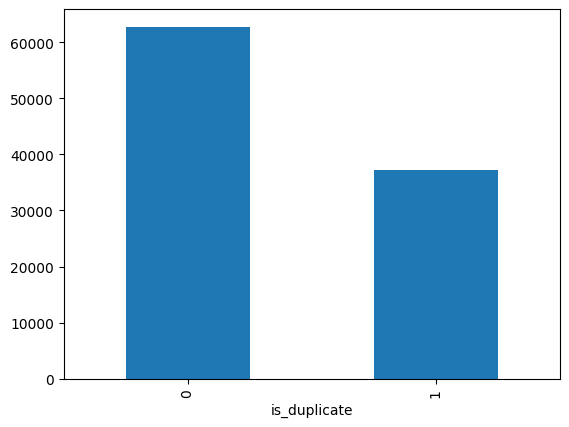

In [14]:
print('Percentage Of is_duplicate Distribution:')
print((df.is_duplicate.value_counts()/df.shape[0])*100)
df.is_duplicate.value_counts().plot(kind='bar')

In [15]:
qid=pd.Series(df['qid1'].tolist()+df['qid2'].tolist())
np.unique(qid).shape[0]

165931

In [16]:
## Counting Unique Questions and Repeated Questions
print('Count of Unique Questions is:', np.unique(qid).shape[0])
repeated=qid.value_counts()>1 # Series
#print(repeated[repeated].shape)
print('Count of Repeated Questions is:',repeated[repeated].shape[0])


Count of Unique Questions is: 165931
Count of Repeated Questions is: 19446


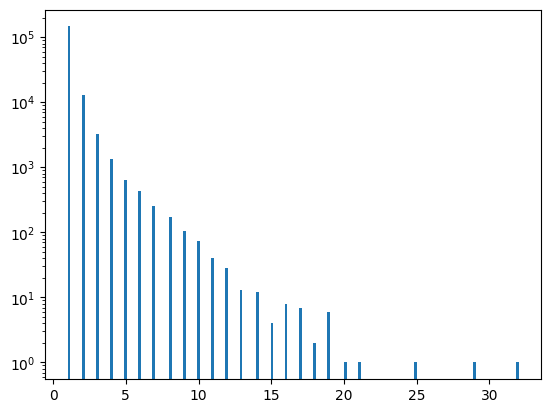

In [17]:
# Repeated questions histogram

plt.hist(qid.value_counts().values,bins=160)
plt.yscale('log')
plt.show()

## 1.Primary Thought is to find the Accuracy of the model with just Bag_of_words

In [18]:
# Dropping the Missing value rows
print(df.shape)
df.dropna(inplace=True)
print(df.shape)

(100000, 6)
(100000, 6)


In [19]:
## My RAM is Insufficient to run entire data.So, Sampling only 40,000 Rows
df=df.sample(30000,random_state=42)

In [20]:
ques_df=df[['question1','question2']]
ques_df.head()

,question1,question2
75721,Why do I root my phone?,What should I do after rooting my phone?
80184,How many times can a man have sex in one night?,Do boys also bleed when they have sex the firs...
19864,Can you help me decide which canon EOS DSLR to...,Which canon EOS DSLR should I get?
76699,How do terrorist groups get their supply of mo...,Where do terrorist organisations get money from?
92991,"When God said he made man in his image, did he...",Did Jimmy Wales ever imagine in his early life...


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=3000)

In [22]:
ques_list=list(ques_df['question1'])+list(ques_df['question1'])
# Transforming the Questions by CountVectorizer(bag of Words) and later splitting the first 30000 into question1 array
# and second 30000 to question2 to match their questions correctly
q1_arr, q2_arr = np.vsplit(cv.fit_transform(ques_list).toarray(),2)

In [23]:
len(q1_arr)

30000

In [24]:
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [25]:
# So, now we have 6000 columns i.e 3000 columns of question1 and another 3000 columns of question2
temp_df['is_duplicate']=df['is_duplicate']
temp_df.shape

(30000, 6001)

In [26]:
temp_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,is_duplicate
75721,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80184,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[:,0:-1].values,temp_df.iloc[:,-1].values,test_size=0.2,random_state=42)

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [29]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)

In [30]:
# If the primary goal is to ensure that as many duplicate question pairs as possible are identified, recall is crucial.
# High recall means the model is catching most of the true duplicates, even if it means having more false positives.
from sklearn.metrics import recall_score,accuracy_score
print('Accuracy Score of RandomForest Classifier is:', accuracy_score(y_test,y_pred))
print('Recall Score of RandomForest Classifier is:', recall_score(y_test,y_pred))
print('----------------------------------------------------')
print('Accuracy Score of XGBClassifier is:', accuracy_score(y_test,y_pred1))
print('Recall Score of XBGClassifier is:', recall_score(y_test,y_pred1))




Accuracy Score of RandomForest Classifier is: 0.7123333333333334
Recall Score of RandomForest Classifier is: 0.463664734730272
----------------------------------------------------
Accuracy Score of XGBClassifier is: 0.7083333333333334
Recall Score of XBGClassifier is: 0.3584485064645564


## 2.To improve Our Model Performance Let's Add Some basic features

### Basic Features:

question 1 Length-> Character length of Question 1.

question 2 Length-> Character length of Question 2.

Q1 Word Count -> No. of Words in Question 1 .

Q2 Word Count -> No. of Words in Question 2.

Words Common -> No. of Common Unique Words.

Words Total -> Total No. of Words in Question 1 and Question 2.

Word Share -> no.of Words common / Words Total.

In [31]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
75721,75721,129541,129542,Why do I root my phone?,What should I do after rooting my phone?,0
80184,80184,136365,136366,How many times can a man have sex in one night?,Do boys also bleed when they have sex the firs...,0
19864,19864,37528,37529,Can you help me decide which canon EOS DSLR to...,Which canon EOS DSLR should I get?,1
76699,76699,131075,131076,How do terrorist groups get their supply of mo...,Where do terrorist organisations get money from?,1
92991,92991,97495,155570,"When God said he made man in his image, did he...",Did Jimmy Wales ever imagine in his early life...,0


In [32]:
df['q1_len'] = df['question1'].str.len()
df['q2_len'] = df['question2'].str.len()

In [33]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len
75721,75721,129541,129542,Why do I root my phone?,What should I do after rooting my phone?,0,23,40
80184,80184,136365,136366,How many times can a man have sex in one night?,Do boys also bleed when they have sex the firs...,0,47,53
19864,19864,37528,37529,Can you help me decide which canon EOS DSLR to...,Which canon EOS DSLR should I get?,1,51,34
76699,76699,131075,131076,How do terrorist groups get their supply of mo...,Where do terrorist organisations get money from?,1,50,48
92991,92991,97495,155570,"When God said he made man in his image, did he...",Did Jimmy Wales ever imagine in his early life...,0,144,101


In [34]:
df['q1_num_words']=df['question1'].apply(lambda question: len(question.split(" "))) # Column-wise
df['q2_num_words']=df['question2'].apply(lambda question: len(question.split(' ')))

In [35]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words
75721,75721,129541,129542,Why do I root my phone?,What should I do after rooting my phone?,0,23,40,6,8
80184,80184,136365,136366,How many times can a man have sex in one night?,Do boys also bleed when they have sex the firs...,0,47,53,11,11


In [36]:
def common_words(row):
  # the map function is applied first, followed by the lambda function being applied to each element,
  # and finally, the set function is used to create a set of the processed words.
  # Syntax of map(): map(fun, iter)
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1.intersection(w2))

In [37]:
df['word_common'] = df.apply(common_words,axis=1) # applying function to each row.
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common
75721,75721,129541,129542,Why do I root my phone?,What should I do after rooting my phone?,0,23,40,6,8,4
80184,80184,136365,136366,How many times can a man have sex in one night?,Do boys also bleed when they have sex the firs...,0,47,53,11,11,2
19864,19864,37528,37529,Can you help me decide which canon EOS DSLR to...,Which canon EOS DSLR should I get?,1,51,34,11,7,5
76699,76699,131075,131076,How do terrorist groups get their supply of mo...,Where do terrorist organisations get money from?,1,50,48,9,7,3
92991,92991,97495,155570,"When God said he made man in his image, did he...",Did Jimmy Wales ever imagine in his early life...,0,144,101,33,18,7


In [38]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return (len(w1) + len(w2))

In [39]:
df['word_total'] = df.apply(total_words, axis=1)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total
75721,75721,129541,129542,Why do I root my phone?,What should I do after rooting my phone?,0,23,40,6,8,4,14
80184,80184,136365,136366,How many times can a man have sex in one night?,Do boys also bleed when they have sex the firs...,0,47,53,11,11,2,22


In [40]:
df['word_share']=np.round(df['word_common']/df['word_total'],2)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
75721,75721,129541,129542,Why do I root my phone?,What should I do after rooting my phone?,0,23,40,6,8,4,14,0.29
80184,80184,136365,136366,How many times can a man have sex in one night?,Do boys also bleed when they have sex the firs...,0,47,53,11,11,2,22,0.09


maximum length of Question1: 413
minimum length of Question1: 1
Average length of Question1: 59.3637


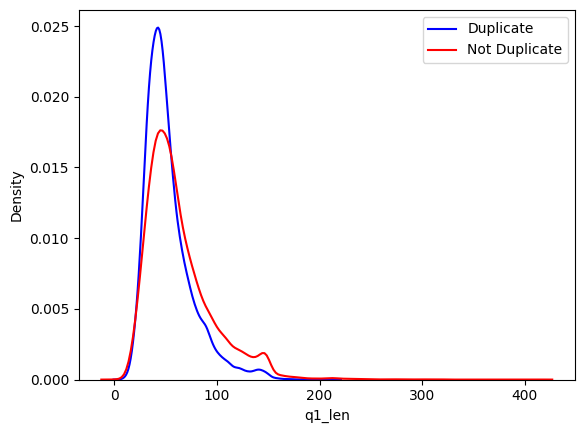

In [41]:
# Distribution of q1_len
sns.kdeplot(df[df['is_duplicate']==1]['q1_len'],color='blue',label='Duplicate')
sns.kdeplot(df[df['is_duplicate']==0]['q1_len'],color='red',label='Not Duplicate')
plt.legend()
print('maximum length of Question1:',max(df['q1_len']))
print('minimum length of Question1:',min(df['q1_len']))
print('Average length of Question1:',np.mean(df['q1_len']))

maximum length of Question2: 1151
minimum length of Question2: 5
Average length of Question2: 59.84503333333333


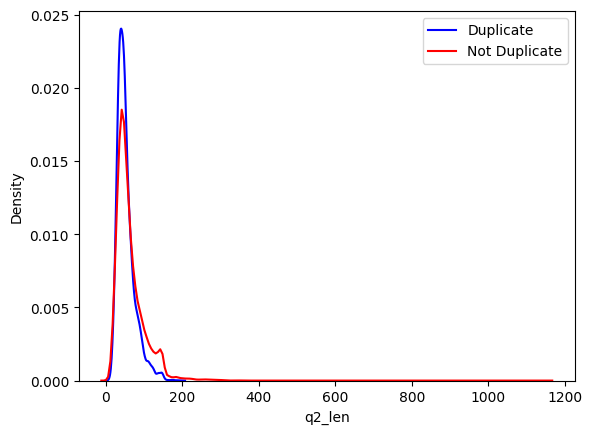

In [42]:
# Distribution of q2_len
sns.kdeplot(df[df['is_duplicate']==1]['q2_len'],color='blue',label='Duplicate')
sns.kdeplot(df[df['is_duplicate']==0]['q2_len'],color='red',label='Not Duplicate')
plt.legend()
print('maximum length of Question2:',max(df['q2_len']))
print('minimum length of Question2:',min(df['q2_len']))
print('Average length of Question2:',np.mean(df['q2_len']))

minimum words 1
maximum words 79
average num of words 10


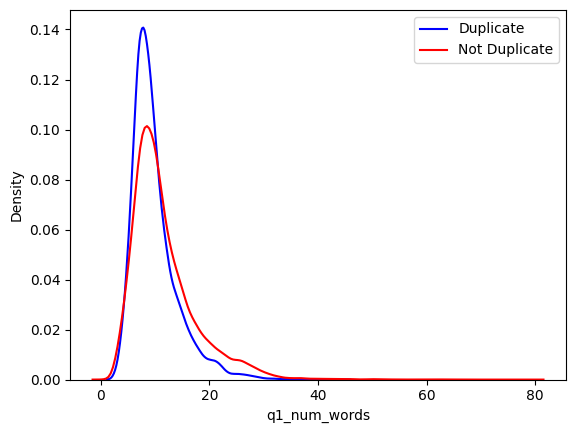

In [43]:
sns.kdeplot(df[df['is_duplicate']==1]['q1_num_words'],label='Duplicate',color='blue')
sns.kdeplot(df[df['is_duplicate']==0]['q1_num_words'],label='Not Duplicate',color='red')
plt.legend()
print('minimum words',df['q1_num_words'].min())
print('maximum words',df['q1_num_words'].max())
print('average num of words',int(df['q1_num_words'].mean()))

minimum words 1
maximum words 237
average num of words 11


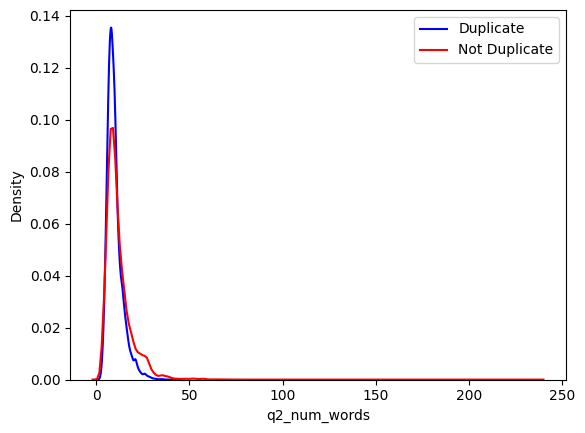

In [44]:
#q2_num_words
sns.kdeplot(df[df['is_duplicate']==1]['q2_num_words'],label='Duplicate',color='blue')
sns.kdeplot(df[df['is_duplicate']==0]['q2_num_words'],label='Not Duplicate',color='red')
plt.legend()
print('minimum words',df['q2_num_words'].min())
print('maximum words',df['q2_num_words'].max())
print('average num of words',int(df['q2_num_words'].mean()))

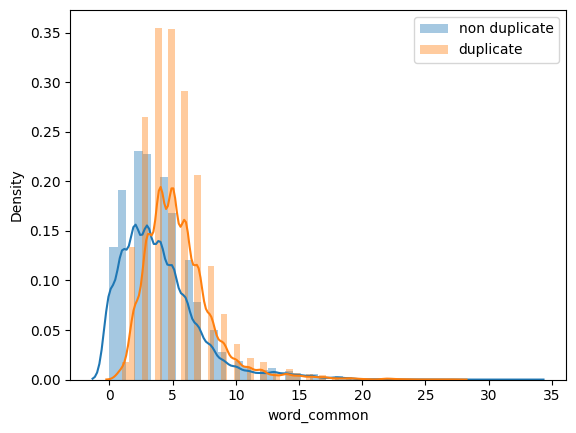

In [45]:
# common words
sns.distplot(df[df['is_duplicate'] == 0]['word_common'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_common'],label='duplicate')
plt.legend()
plt.show()

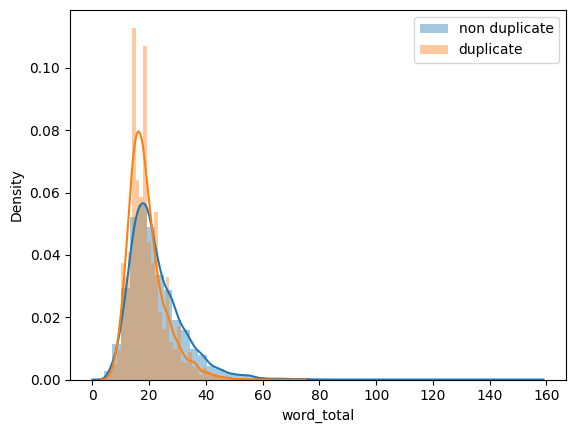

In [46]:
# total words
sns.distplot(df[df['is_duplicate'] == 0]['word_total'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_total'],label='duplicate')
plt.legend()
plt.show()

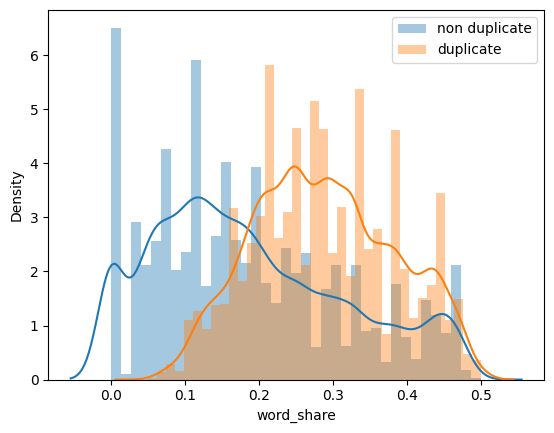

In [47]:
# word share
sns.distplot(df[df['is_duplicate'] == 0]['word_share'],label='non duplicate')
sns.distplot(df[df['is_duplicate'] == 1]['word_share'],label='duplicate')
plt.legend()
plt.show()

In [48]:
ques_df=df[['question1','question2']]
ques_df.head()

,question1,question2
75721,Why do I root my phone?,What should I do after rooting my phone?
80184,How many times can a man have sex in one night?,Do boys also bleed when they have sex the firs...
19864,Can you help me decide which canon EOS DSLR to...,Which canon EOS DSLR should I get?
76699,How do terrorist groups get their supply of mo...,Where do terrorist organisations get money from?
92991,"When God said he made man in his image, did he...",Did Jimmy Wales ever imagine in his early life...


In [49]:
new_df=df.drop(columns=['id','qid1','qid2','question1','question2'])

In [50]:
new_df.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
75721,0,23,40,6,8,4,14,0.29
80184,0,47,53,11,11,2,22,0.09
19864,1,51,34,11,7,5,18,0.28
76699,1,50,48,9,7,3,16,0.19
92991,0,144,101,33,18,7,45,0.16


In [51]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(max_features=3000)
ques_list=list(ques_df['question1'])+list(ques_df['question1'])
# Transforming the Questions by CountVectorizer(bag of Words) and later splitting the first 30000 into question1 array
# and second 30000 to question2 to match their questions correctly
q1_arr, q2_arr = np.vsplit(cv.fit_transform(ques_list).toarray(),2)
temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)
temp_df.shape

(30000, 6000)

In [52]:
final_df=pd.concat([new_df,temp_df],axis=1)

In [53]:
final_df.head()

,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
75721,0,23,40,6,8,4,14,0.29,0,0,...,0,0,0,0,0,0,0,0,0,0
80184,0,47,53,11,11,2,22,0.09,0,0,...,0,0,0,0,0,0,0,0,0,0
19864,1,51,34,11,7,5,18,0.28,0,0,...,0,1,0,0,0,0,0,0,0,0
76699,1,50,48,9,7,3,16,0.19,0,0,...,0,0,0,0,0,0,0,0,0,0
92991,0,144,101,33,18,7,45,0.16,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=42)

In [55]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

In [56]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)

In [57]:
# If the primary goal is to ensure that as many duplicate question pairs as possible are identified, recall is crucial.
# High recall means the model is catching most of the true duplicates, even if it means having more false positives.
from sklearn.metrics import recall_score,accuracy_score
print('Accuracy Score of RandomForest Classifier is:', accuracy_score(y_test,y_pred))
print('Recall Score of RandomForest Classifier is:', recall_score(y_test,y_pred))
print('----------------------------------------------------')
print('Accuracy Score of XGBClassifier is:', accuracy_score(y_test,y_pred1))
print('Recall Score of XBGClassifier is:', recall_score(y_test,y_pred1))

Accuracy Score of RandomForest Classifier is: 0.7635
Recall Score of RandomForest Classifier is: 0.6139099420419082
----------------------------------------------------
Accuracy Score of XGBClassifier is: 0.7651666666666667
Recall Score of XBGClassifier is: 0.6959429335711101


### We Can See a slight Improvement in Both Accuracy and Recall Score. Adding Some of the Advanced Features will increase the Performance of the Model. This Advanced  Features were created by reading the Discussion Section and understanding the Top 3 Models in Quora Duplicate Question Pairs Competition Organized by Quora.

## Advanced Features
**1. Token** **Features**

**cwc_min**: This is the ratio of the number of common words to the length of the smaller question.

**cwc_max**: This is the ratio of the number of common words to the length of the larger question

**csc_min**: This is the ratio of the number of common stop words to the smaller stop word count among the two questions

**csc_max**: This is the ratio of the number of common stop words to the larger stop word count among the two questions

**ctc_min**: This is the ratio of the number of common tokens to the smaller token count among the two questions

**ctc_max**: This is the ratio of the number of common tokens to the larger token count among the two questions

**last_word_eq**: 1 if the last word in the two questions is same, 0 otherwise

**first_word_eq**: 1 if the first word in the two questions is same, 0 otherwise

**2**. **Length Based Features**

**mean_len**: Mean of the length of the two questions (number of words)

**abs_len_diff**: Absolute difference between the length of the two questions (number of words)

**longest_substr_ratio**: Ratio of the length of the longest substring among the two questions to the length of the smaller question

**3. Fuzzy Features**

**fuzz_ratio**: fuzz_ratio score from fuzzywuzzy

**fuzz_partial_ratio**: fuzz_partial_ratio from fuzzywuzzy

**token_sort_ratio**: token_sort_ratio from fuzzywuzzy

**token_set_ratio**: token_set_ratio from fuzzywuzzy

In [58]:
import re
from bs4 import BeautifulSoup

def preprocess(q):

    q = str(q).lower().strip()

    # Replacing certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')

    # The pattern '[math]' appears around 900 times in the whole dataset.so,just removing it.
    q = q.replace('[math]', '')

    # Replacing some numbers with string equivalents
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)

    # Decontracting words

    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953

    contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
          # Decontracting it it is in dictonary
            word = contractions[word]
        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Removing HTML tags with bs
    q = BeautifulSoup(q)
    q = q.get_text()

    # Remove punctuations using regular expression
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    return q


Example

In [59]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [60]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
75721,75721,129541,129542,Why do I root my phone?,What should I do after rooting my phone?,0,23,40,6,8,4,14,0.29
80184,80184,136365,136366,How many times can a man have sex in one night?,Do boys also bleed when they have sex the firs...,0,47,53,11,11,2,22,0.09
19864,19864,37528,37529,Can you help me decide which canon EOS DSLR to...,Which canon EOS DSLR should I get?,1,51,34,11,7,5,18,0.28
76699,76699,131075,131076,How do terrorist groups get their supply of mo...,Where do terrorist organisations get money from?,1,50,48,9,7,3,16,0.19
92991,92991,97495,155570,"When God said he made man in his image, did he...",Did Jimmy Wales ever imagine in his early life...,0,144,101,33,18,7,45,0.16


In [61]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [62]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share
75721,75721,129541,129542,why do i root my phone,what should i do after rooting my phone,0,23,40,6,8,4,14,0.29
80184,80184,136365,136366,how many times can a man have sex in one night,do boys also bleed when they have sex the firs...,0,47,53,11,11,2,22,0.09
19864,19864,37528,37529,can you help me decide which canon eos dslr to...,which canon eos dslr should i get,1,51,34,11,7,5,18,0.28
76699,76699,131075,131076,how do terrorist groups get their supply of money,where do terrorist organisations get money from,1,50,48,9,7,3,16,0.19
92991,92991,97495,155570,when god said he made man in his image did he...,did jimmy wales ever imagine in his early life...,0,144,101,33,18,7,45,0.16


In [63]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [64]:
# Advanced Features
from nltk.corpus import stopwords
def fetch_token_features(row):

    q1 = row['question1'] # series Datatype
    q2 = row['question2']

    SAFE_DIV = 0.0001 # it is just to ensure we don't get error when min length of word count =0.

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8 # if tokens in sentence =0

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split() # creating tokens using split function
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features

In [65]:
token_features = df.apply(fetch_token_features, axis=1)

# Creating Advanced Features
df["cwc_min"]= list(map(lambda x: x[0], token_features))
df["cwc_max"]= list(map(lambda x: x[1], token_features))
df["csc_min"]= list(map(lambda x: x[2], token_features))
df["csc_max"]= list(map(lambda x: x[3], token_features))
df["ctc_min"]= list(map(lambda x: x[4], token_features))
df["ctc_max"]= list(map(lambda x: x[5], token_features))
df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [66]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'word_common',
       'word_total', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq'],
      dtype='object')

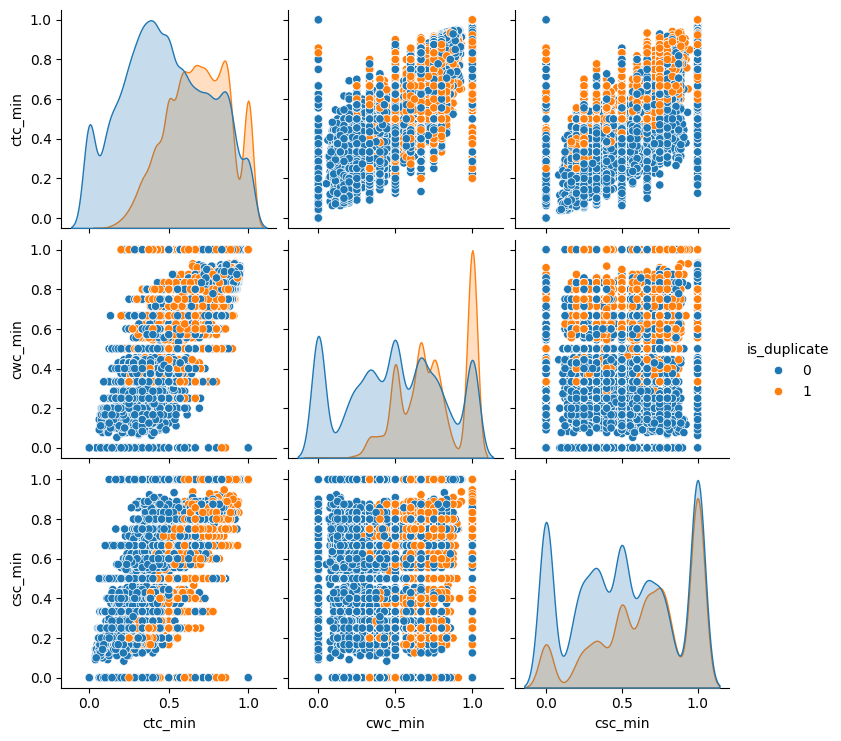

In [67]:
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'is_duplicate']],hue='is_duplicate')

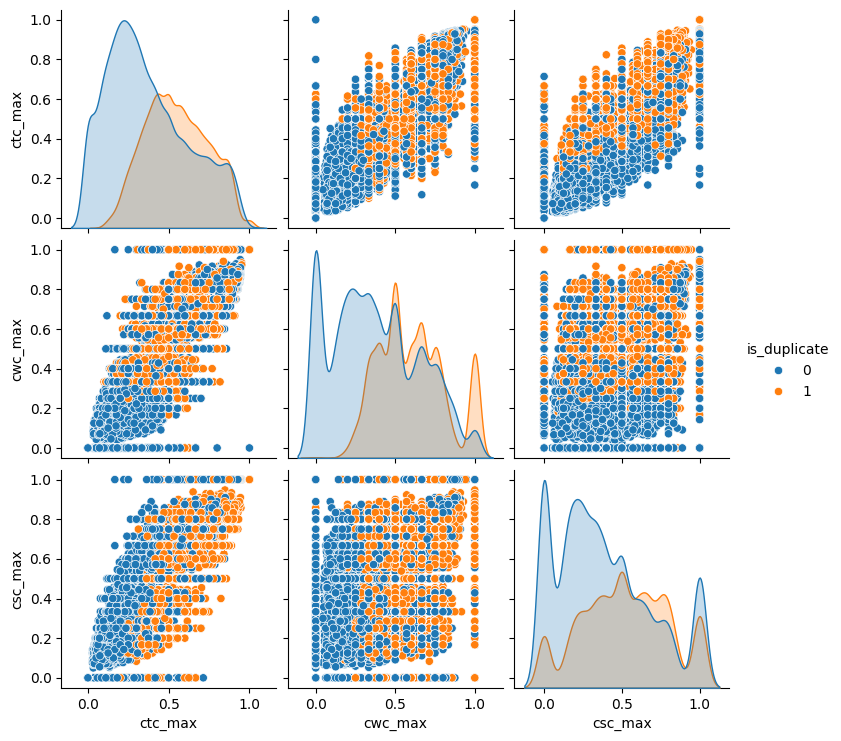

In [68]:
sns.pairplot(df[['ctc_max', 'cwc_max', 'csc_max', 'is_duplicate']],hue='is_duplicate')

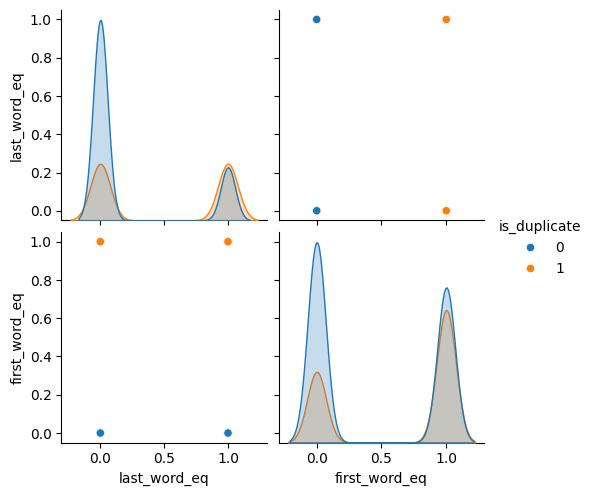

In [69]:
sns.pairplot(df[['last_word_eq', 'first_word_eq', 'is_duplicate']],hue='is_duplicate')

In [70]:
!pip install Distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=8c386820c7e38a2372bfe169b7e3f12875b29b2fffa2975267f049827250d6d3
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built Distance


In [71]:
import distance
# Length Features or Token Features
def fetch_length_features(row):

    q1 = row['question1']
    q2 = row['question2']

    length_features = [0.0]*3 #if tokens length =0

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    # longest substring ratio=len(common substring)/min(tokens in q1 anq2)
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features

In [72]:
length_features = df.apply(fetch_length_features, axis=1)

df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
df['mean_len'] = list(map(lambda x: x[1], length_features))
df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [73]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'word_common',
       'word_total', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'longest_substr_ratio'],
      dtype='object')

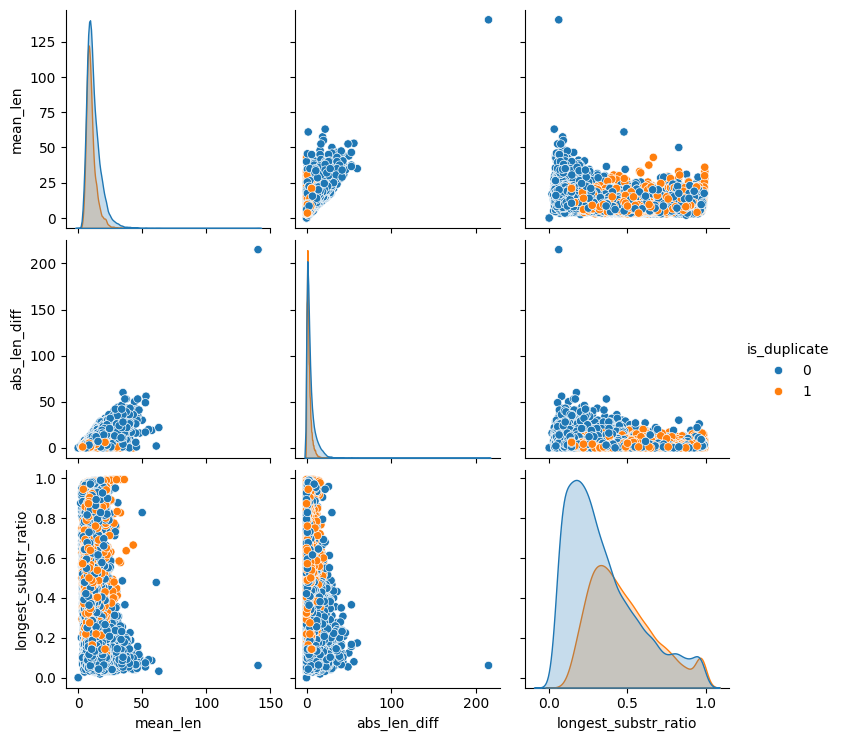

In [74]:
sns.pairplot(df[['mean_len', 'abs_len_diff','longest_substr_ratio', 'is_duplicate']],hue='is_duplicate')

In [75]:
!pip install fuzzywuzzy

In [76]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):

    q1 = row['question1']
    q2 = row['question2']

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [77]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [78]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_words', 'q2_num_words', 'word_common',
       'word_total', 'word_share', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'longest_substr_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'token_sort_ratio', 'token_set_ratio'],
      dtype='object')

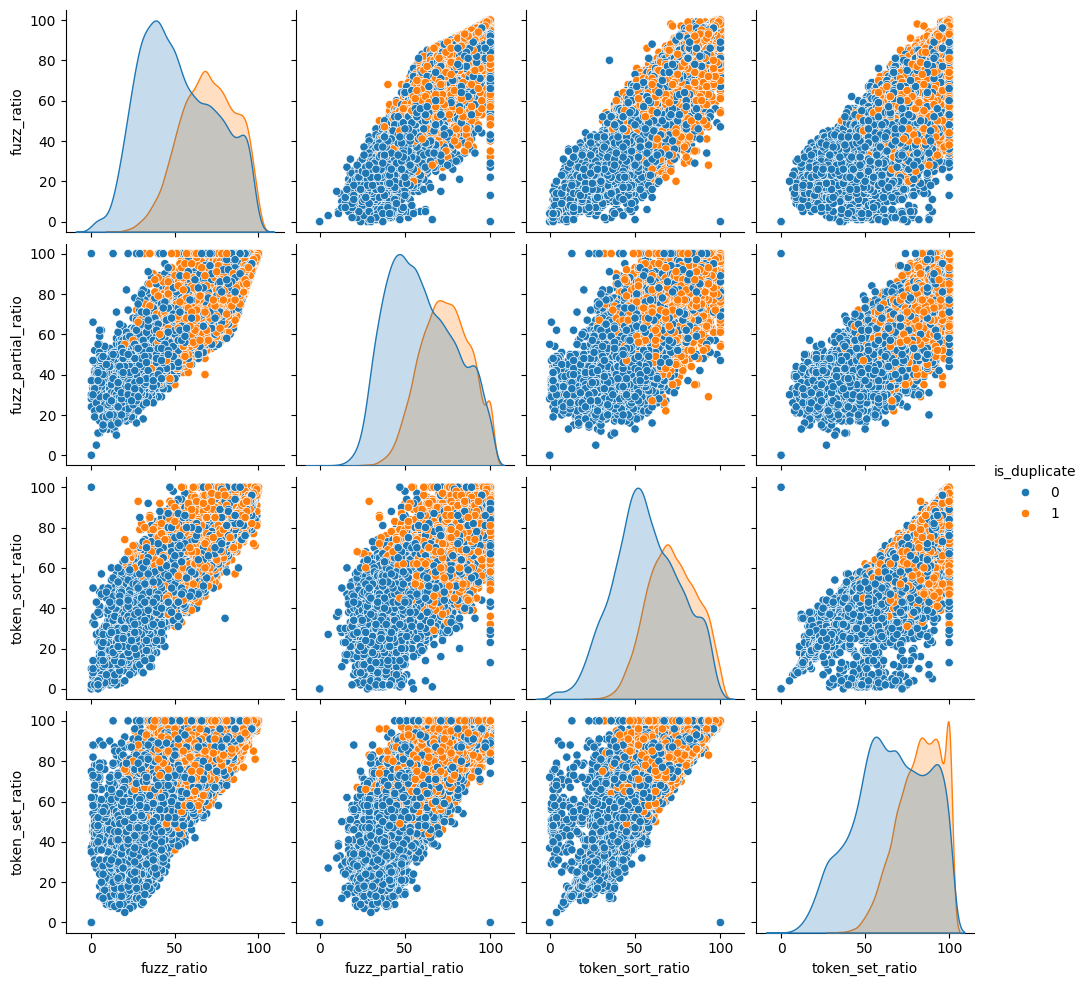

In [79]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

In [80]:
ques_df = df[['question1','question2']]
final_df = df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(ques_df['question1']) + list(ques_df['question2'])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)
print('Shape of q1_arr:',q1_arr.shape)

temp_df1 = pd.DataFrame(q1_arr, index= ques_df.index)
temp_df2 = pd.DataFrame(q2_arr, index= ques_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)

final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)

(30000, 23)
Shape of q1_arr: (30000, 3000)
(30000, 6023)


In [81]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[:,1:].values,final_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [82]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)


In [83]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)


In [84]:
# If the primary goal is to ensure that as many duplicate question pairs as possible are identified, recall is crucial.
# High recall means the model is catching most of the true duplicates, even if it means having more false positives.
from sklearn.metrics import recall_score,accuracy_score
print('Accuracy Score of RandomForest Classifier is:', accuracy_score(y_test,y_pred))
print('Recall Score of RandomForest Classifier is:', recall_score(y_test,y_pred))
print('----------------------------------------------------')
print('Accuracy Score of XGBClassifier is:', accuracy_score(y_test,y_pred1))
print('Recall Score of XBGClassifier is:', recall_score(y_test,y_pred1))

Accuracy Score of RandomForest Classifier is: 0.794
Recall Score of RandomForest Classifier is: 0.7152145643693107
----------------------------------------------------
Accuracy Score of XGBClassifier is: 0.7943333333333333
Recall Score of XBGClassifier is: 0.7308192457737321


## XGBClassifier is OutPerforming RandomForest in Both Accuracy and Mainly the Recall Score.

## Cross Validation

## I Can't do Cross Validation and Parameter Tunning Due to RAM Issues.

In [ ]:
print('XGBClassifier Metrics')
from sklearn.model_selection import cross_val_score
scores = cross_val_score(xgb, X_train, y_train, cv=3, scoring='recall',n_jobs=-1)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

In [ ]:
print('Random Forest Classifier Metrics')
scores = cross_val_score(xgb, X_train, y_train, cv=3, scoring='recall',n_jobs=-1)
print("Cross-validation scores: ", scores)
print("Mean cross-validation score: ", scores.mean())

## Creating Function which would help in turning the test questions into Our array from of (1,6022)

In [85]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return len(w1 & w2)
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))
    return (len(w1) + len(w2))

In [86]:
def test_fetch_token_features(q1,q2):

    SAFE_DIV = 0.0001

    STOP_WORDS = stopwords.words("english")

    token_features = [0.0]*8

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))

    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))

    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))


    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)

    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])

    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])

    return token_features
def test_fetch_length_features(q1,q2):

    length_features = [0.0]*3

    # Converting the Sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features

    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2

    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)

    return length_features

In [87]:
def test_fetch_fuzzy_features(q1,q2):

    fuzzy_features = [0.0]*4

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [88]:
def query_point_creator(q1,q2):

    input_query = []

    # preprocess -> Basic Cleaning

    q1 = preprocess(q1)
    q2 = preprocess(q2)

    # 1.fetching  basic features

    # character counts
    input_query.append(len(q1))
    input_query.append(len(q2))
    #word count
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    # common words,Total words and word share
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))

    # 2.fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)

    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)

    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)

    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()

    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()

    # Horizontally Concatenating all our customized feature and CountVectorizer Features of Both Questions.
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))

In [89]:
q1 = 'Where is the capital of India?'
q2 = 'What is the current capital of Pakistan?'
q3 = 'Which city serves as the capital of India?'
q4 = 'What is the business capital of India?'

In [90]:
xgb.predict(query_point_creator(q1,q4))

array([0])

In [91]:
xgb.predict(query_point_creator(q2,q3))

array([0])

## Dumping Both CountVectorizer and XGBClassifier using pickle

In [92]:
cv

CountVectorizer(max_features=3000)

In [93]:
!pip install pickle5

In [94]:
import pickle
pickle.dump(xgb,open('model.pkl','wb'))
pickle.dump(cv,open('cv.pkl','wb'))